In [135]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 30

METRICS_MAP = {
    "exec_time": "実行時間 (秒)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "利用者満足度",
    "mean_max_envy": "Mean Max Envy",
    "pct_item_util_better": "% Items Better Off",
    "pct_item_util_worse": "% Items Worse Off",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "Greedy",
    "expo_fair": "Exposure-Based",
    "nsw": "NSW",
    "greedy_nsw": "Greedy-NSW",
    "ot_nsw": "OT-NSW（Ours）",
}
METHOD_NAMES = list(METHOD_MAP.values())

COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
PALLETE = COLORS[: len(METHOD_NAMES)]

# print method to color
for method, color in zip(METHOD_NAMES, PALLETE):
    print(f"{method}: {color}")

Greedy: #E24A33
Exposure-Based: #348ABD
NSW: #988ED5
Greedy-NSW: #777777
OT-NSW（Ours）: #FBC15E


In [136]:
def load_result(
    path: Path,
    exp_names: list[str],
    on: list[str] = ["seed"],
    ignore_methods: list[str] = ["pg_ot"],
    dropna: bool = True,
) -> pd.DataFrame:
    result = pd.read_csv(path)

    # Filter by experiment name
    result = result.query(f"exp_name in {exp_names}")
    # # Filter by optimizer params method
    result = result.query(f"optimizer_params_method not in {ignore_methods}").reset_index(
        drop=True
    )

    # Initialize metrics
    result["exec_time_rate"] = np.nan

    # rename method
    result["method"] = result["optimizer_name"].map(METHOD_MAP)

    #
    ideal = result.query("method == 'NSW'").reset_index(drop=True)
    result = pd.merge(
        result[on + ["method"] + METRICS],
        ideal[on + METRICS],
        on=on,
        suffixes=("", "_nsw"),
        how="left",
    )

    # Calculate exec_time_rate
    result["exec_time_rate"] = result["exec_time"] / result["exec_time_nsw"]

    # drop na
    num_na: pd.DataFrame = result[METRICS].isna().sum(axis=0).to_frame()
    num_na.columns = ["number_of_nan"]
    display(num_na)
    if dropna:
        result = result.dropna(subset=METRICS)

    return result.reset_index(drop=True)

# ベースサイズの実験

## データの読み込み

In [137]:
base_size_result = load_result(
    path=Path("../output/result.csv"),
    exp_names=["exp_base"],
    on=["generator_n_query", "generator_n_doc", "generator_K", "seed"],
)
base_size_result.head(5)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_query,generator_n_doc,generator_K,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1000,500,10,4,OT-NSW（Ours）,8.352898,0.016294,2.163754,0.000043,96.8,0.4,512.639917,NaN,2.158096,0.000038,97.0,0.0
1,1000,500,10,3,OT-NSW（Ours）,8.293282,0.016120,2.191015,0.000045,96.0,0.0,514.471181,NaN,2.184864,0.000041,97.4,0.0
2,1000,500,10,2,OT-NSW（Ours）,8.475536,0.016358,2.149408,0.000045,96.0,0.2,518.140154,NaN,2.143812,0.000037,97.0,0.2
3,1000,500,10,1,OT-NSW（Ours）,8.548269,0.016041,2.151742,0.000047,97.2,0.2,532.893298,NaN,2.145651,0.000039,97.8,0.0
4,1000,500,10,0,OT-NSW（Ours）,9.120509,0.016737,2.161028,0.000044,96.4,0.2,544.940438,NaN,2.155045,0.000040,97.2,0.0


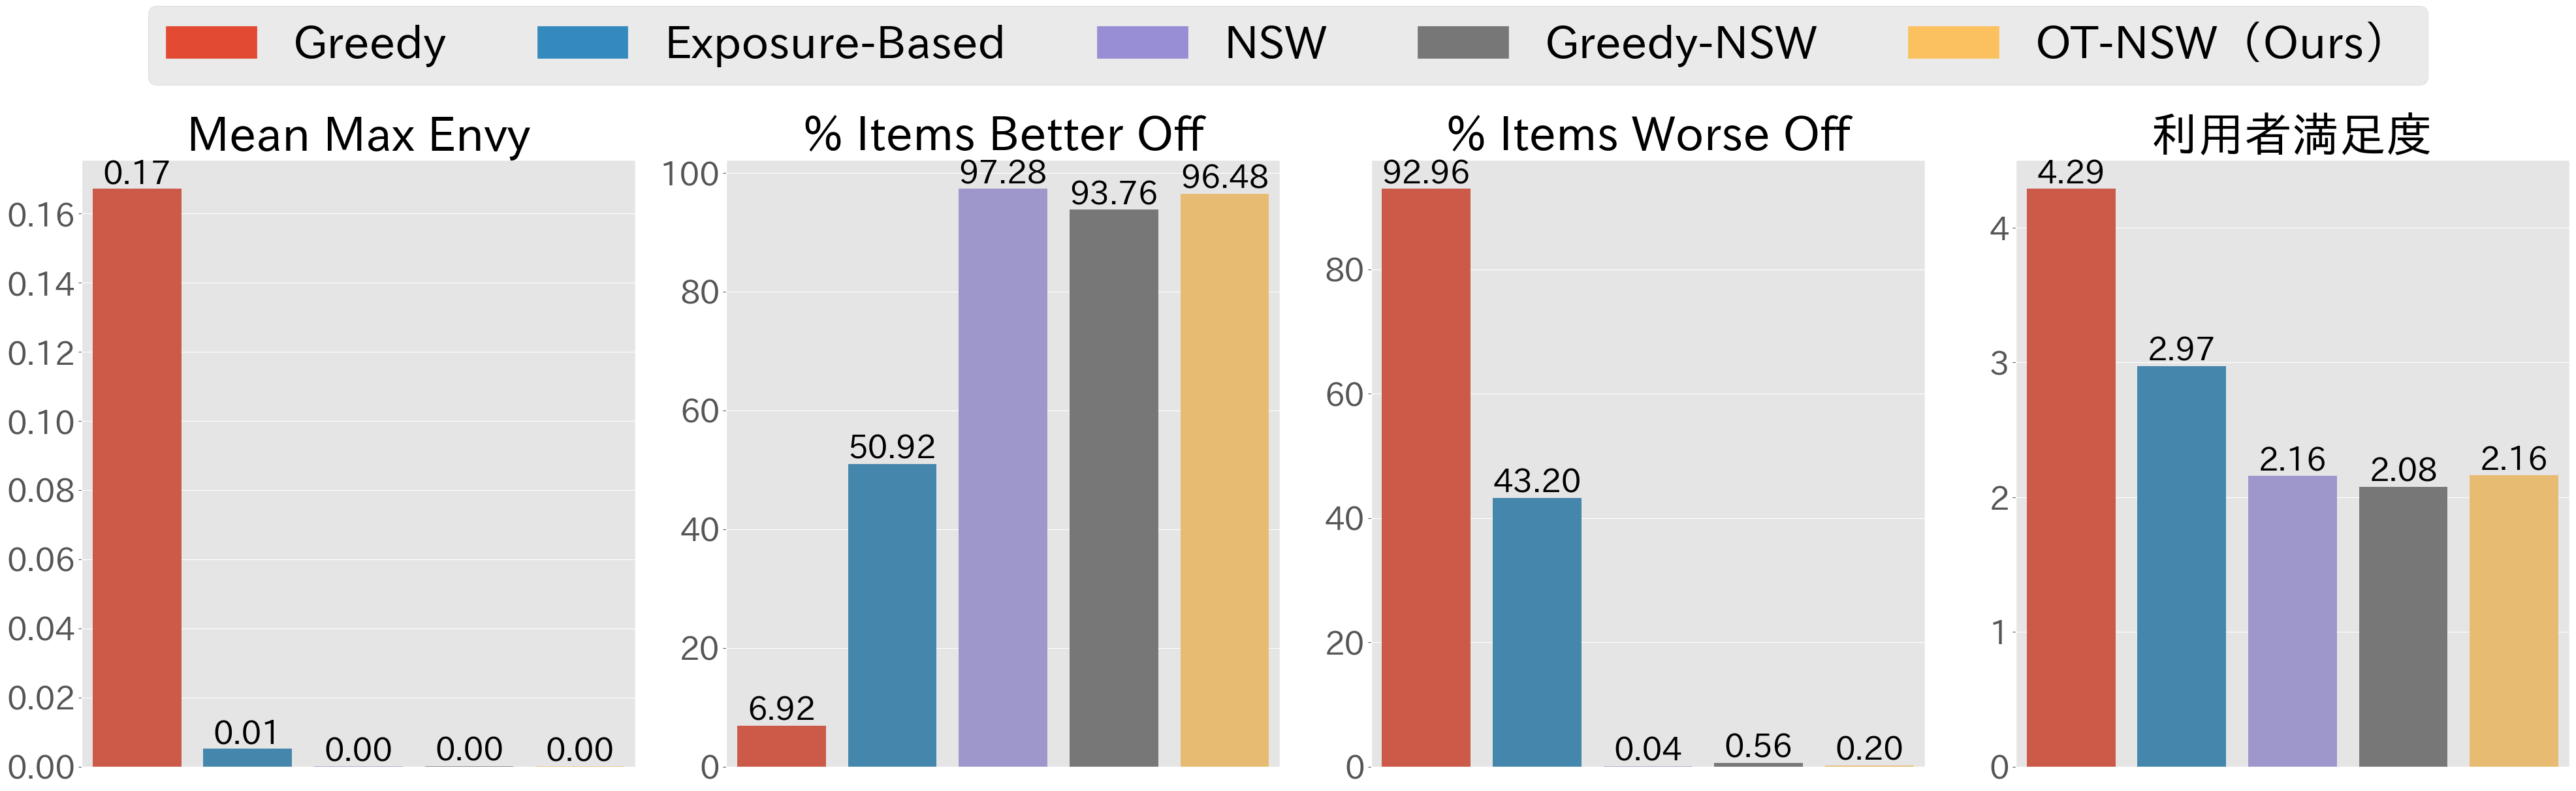

In [138]:
fig, axes = plt.subplots(ncols=4, figsize=(40, 11), tight_layout=True)
axes = np.ravel(axes)
for i, metric in enumerate(
    ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
):
    ax = sns.barplot(
        base_size_result,
        x="method",
        y=metric,
        ax=axes[i],
        legend=False,
        order=METHOD_NAMES,
        palette=PALLETE,
        hue="method",
        hue_order=METHOD_NAMES,
        errorbar=None,
    )
    # 棒グラフの上に値を追加
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=35,
        )

    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="both", labelsize=35)
    ax.set_xticks([])

handles = [plt.Rectangle((0, 0), 1, 1, color=PALLETE[i]) for i in range(len(METHOD_NAMES))]
fig.legend(
    handles,
    METHOD_NAMES,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(METHOD_NAMES),
    loc="upper center",
)

# アイテム数を変化させたときの実験

## データの読み込み

In [139]:
varying_item_size_result = load_result(
    path=Path("../output/result.csv"),
    exp_names=["Varying_data_size"],
    on=["generator_n_doc", "seed"],
)
varying_item_size_result.head(5)

,number_of_nan
exec_time,0
exec_time_rate,10
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,OT-NSW（Ours）,19.905832,0.008170,2.174512,0.000046,96.4375,0.125,2436.438661,NaN,2.170236,0.000014,97.625,0.0625
1,800,4,OT-NSW（Ours）,8.429891,0.011844,2.163305,0.000035,96.3750,0.375,711.735993,NaN,2.166696,0.000026,96.875,0.0000
2,400,4,OT-NSW（Ours）,3.769297,0.025438,2.174666,0.000059,96.7500,0.250,148.177765,NaN,2.168780,0.000051,96.500,0.0000
3,200,4,OT-NSW（Ours）,1.861221,0.043018,2.147440,0.000122,96.0000,0.500,43.266067,NaN,2.140489,0.000099,97.000,0.0000
4,100,4,OT-NSW（Ours）,1.087453,0.094224,2.163796,0.000292,98.0000,1.000,11.541121,NaN,2.154870,0.000238,98.000,0.0000


## 公平性、満足度のプロット

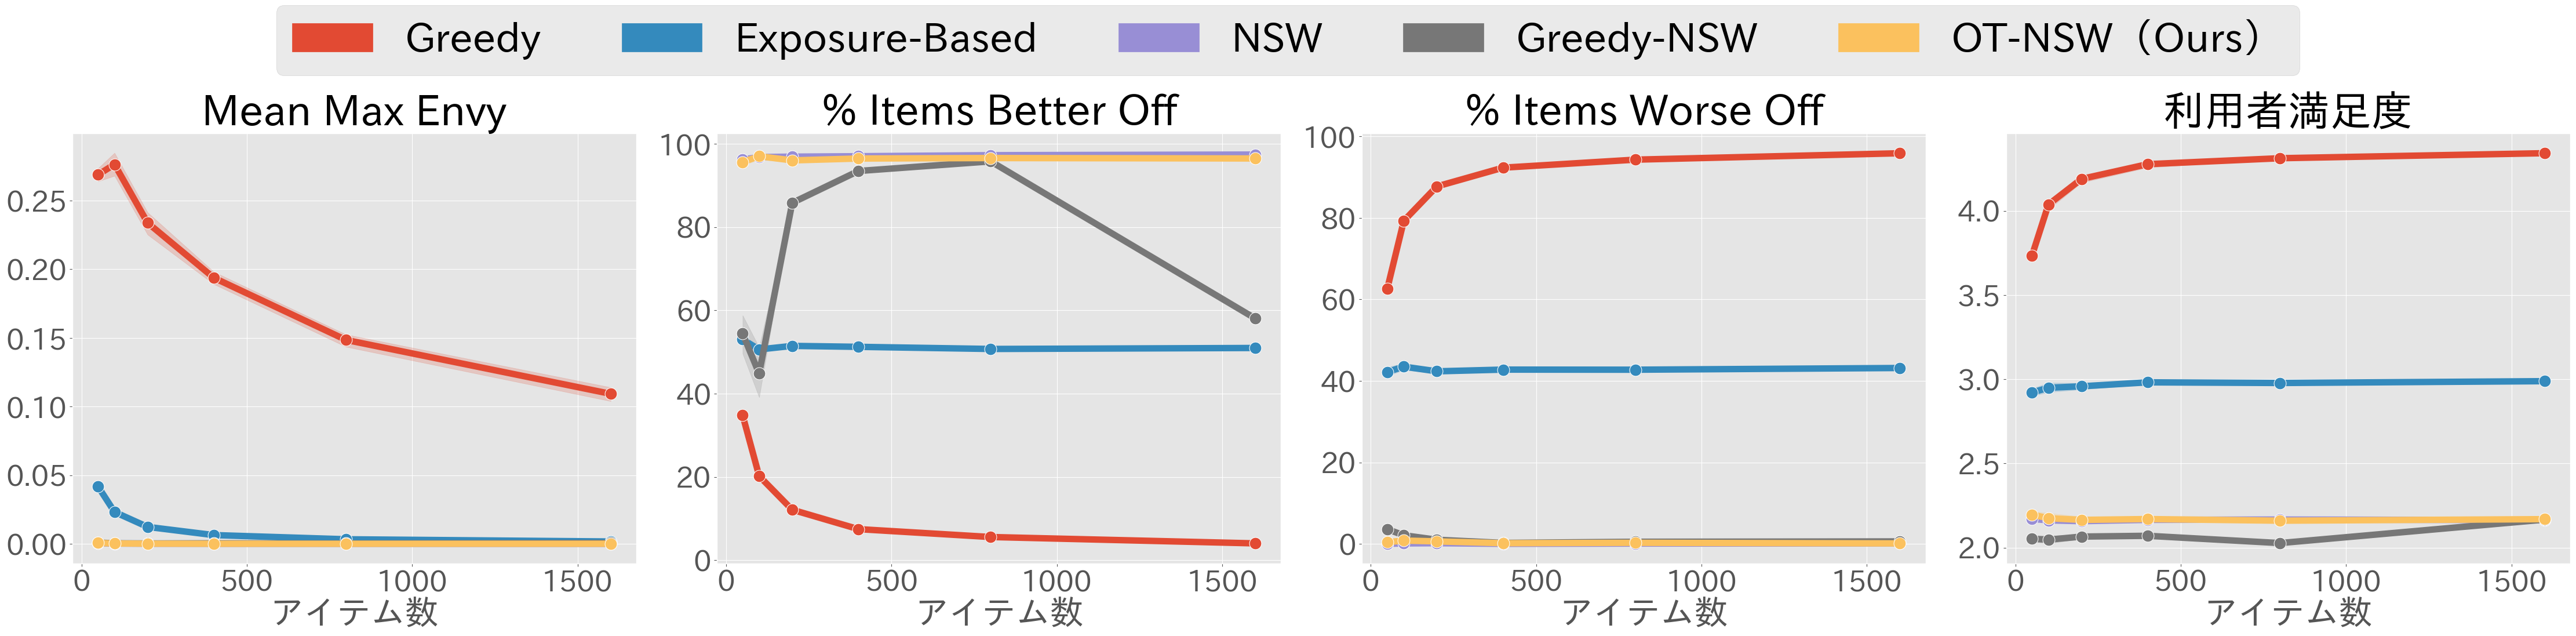

In [141]:
fig, axes = plt.subplots(ncols=4, figsize=(45, 10), tight_layout=True)
axes = np.ravel(axes)
for i, metric in enumerate(
    ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
):
    ax = sns.lineplot(
        varying_item_size_result,
        x="generator_n_doc",
        y=metric,
        hue="method",
        ax=axes[i],
        marker="o",
        markersize=15,
        markers=True,
        linewidth=8,
        legend=False,
        palette=PALLETE,
        hue_order=METHOD_NAMES,
    )
    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("アイテム数", fontsize=42)
    ax.tick_params(axis="both", labelsize=35)

handles = [plt.Rectangle((0, 0), 1, 1, color=PALLETE[i]) for i in range(len(METHOD_NAMES))]
fig.legend(
    handles,
    METHOD_NAMES,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(METHOD_NAMES),
    loc="upper center",
)

## 実行時間のプロット

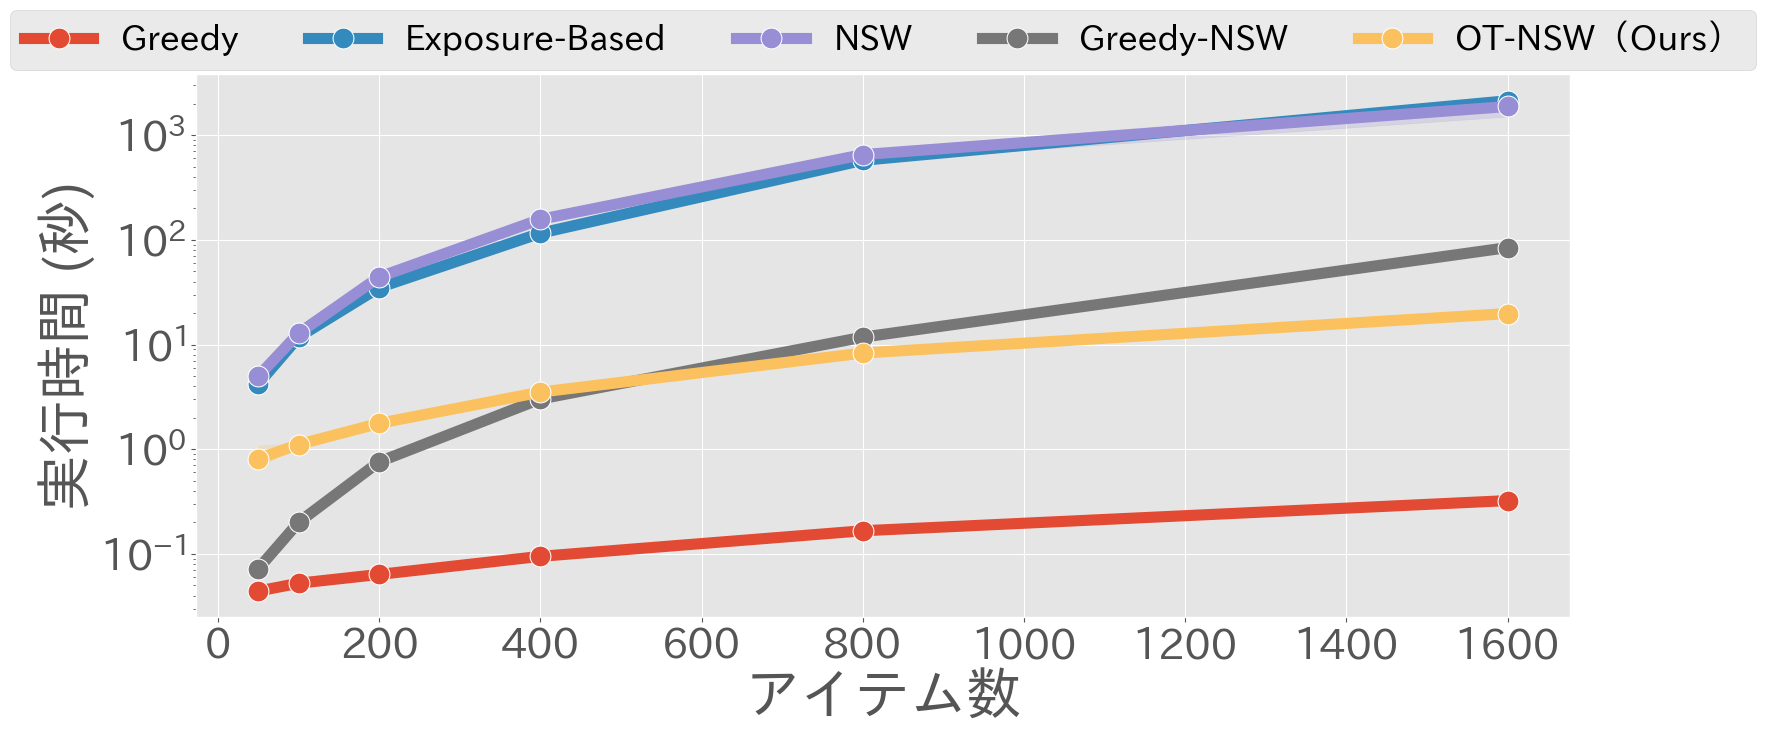

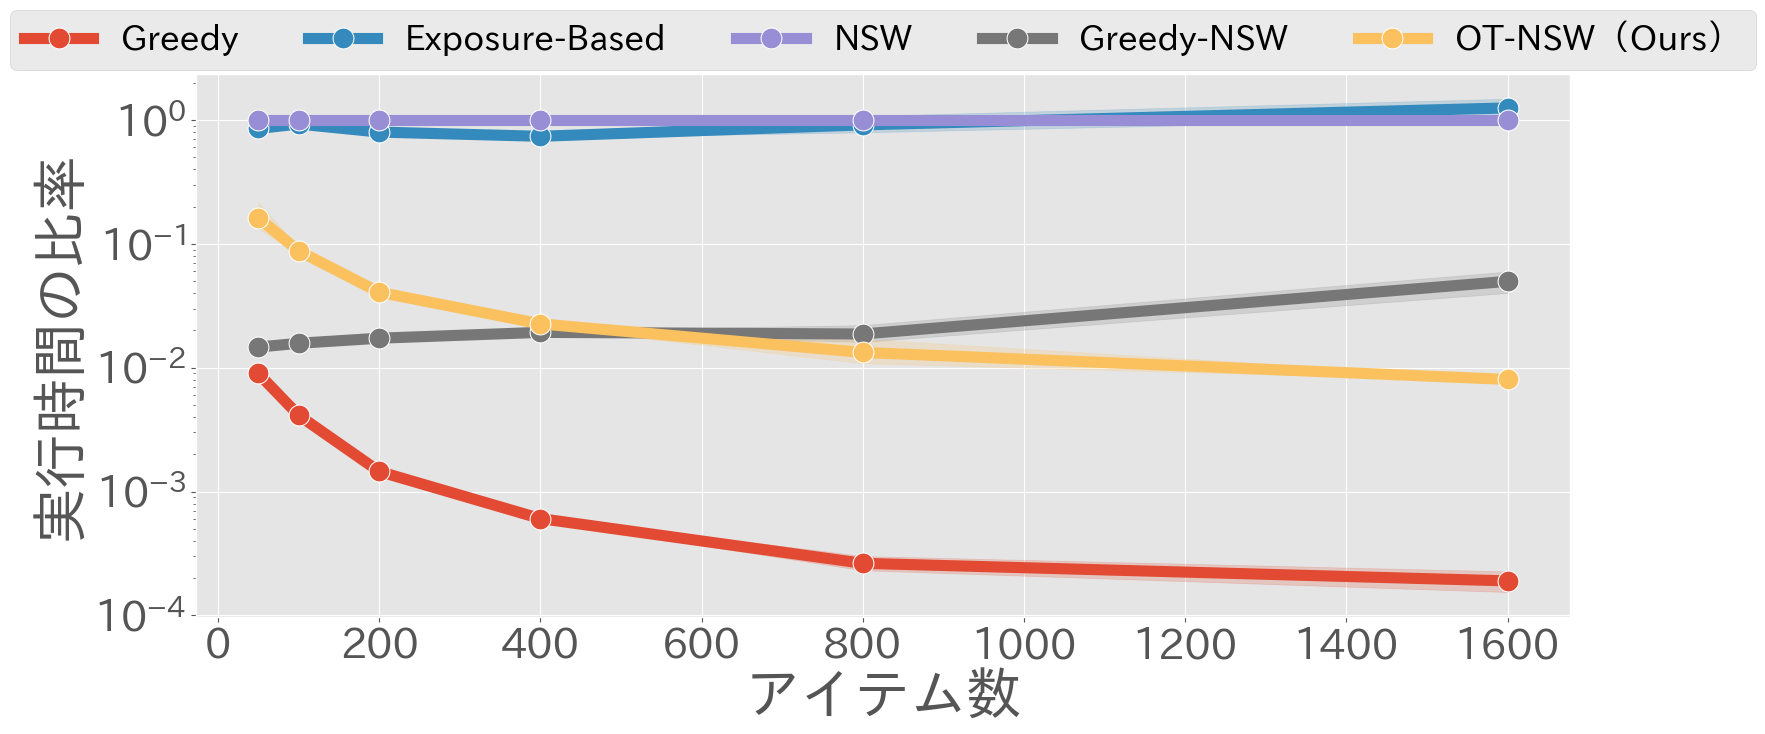

In [142]:
for i, metric in enumerate(["exec_time", "exec_time_rate"]):
    fig = plt.figure(figsize=(18, 8))
    ax = sns.lineplot(
        varying_item_size_result,
        x="generator_n_doc",
        y=metric,
        hue="method",
        marker="o",
        markers=True,
        markersize=15,
        linewidth=8,
        legend=True,
        palette=PALLETE,
        hue_order=METHOD_NAMES,
    )
    # ax.set_title(METRICS_MAP[metric], fontsize=30)
    ax.set_ylabel(METRICS_MAP[metric], fontsize=40)
    ax.set_xlabel("アイテム数", fontsize=40)

    if metric in ["exec_time", "exec_time_rate"]:
        ax.set_yscale("log")

    handles, legend = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        legend,
        loc="upper center",
        ncol=len(legend),
        bbox_to_anchor=(0.5, 1.15),
        # fontsize=40,
    )
    ax.tick_params(axis="both", labelsize=30)

    fig.tight_layout()

# 利用者数を変化させたときの実験

## データの読み込み

In [143]:
varying_user_size_result = load_result(
    path=Path("../output/result.csv"),
    exp_names=["exp_user"],
    on=["generator_n_query", "generator_n_doc", "generator_K", "seed"],
    dropna=False,
)
varying_user_size_result.head(5)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_query,generator_n_doc,generator_K,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,500,10,4,OT-NSW（Ours）,13.226197,0.014771,2.173196,0.000042,96.4,0.0,895.396821,NaN,2.167042,0.000036,96.8,0.0
1,800,500,10,4,OT-NSW（Ours）,6.990836,0.016719,2.164139,0.000048,96.2,0.2,418.126501,NaN,2.158268,0.000039,96.4,0.0
2,400,500,10,4,OT-NSW（Ours）,3.703617,0.012886,2.177809,0.000051,96.6,0.4,287.414595,NaN,2.172414,0.000044,98.2,0.2
3,200,500,10,4,OT-NSW（Ours）,2.455925,0.015409,2.163572,0.000065,96.0,0.0,159.381404,NaN,2.159656,0.000045,97.0,0.4
4,100,500,10,4,OT-NSW（Ours）,2.356256,0.087857,2.180086,0.000075,97.0,0.6,26.819246,NaN,2.168920,0.000050,97.6,0.6


## 公平性、満足度のプロット

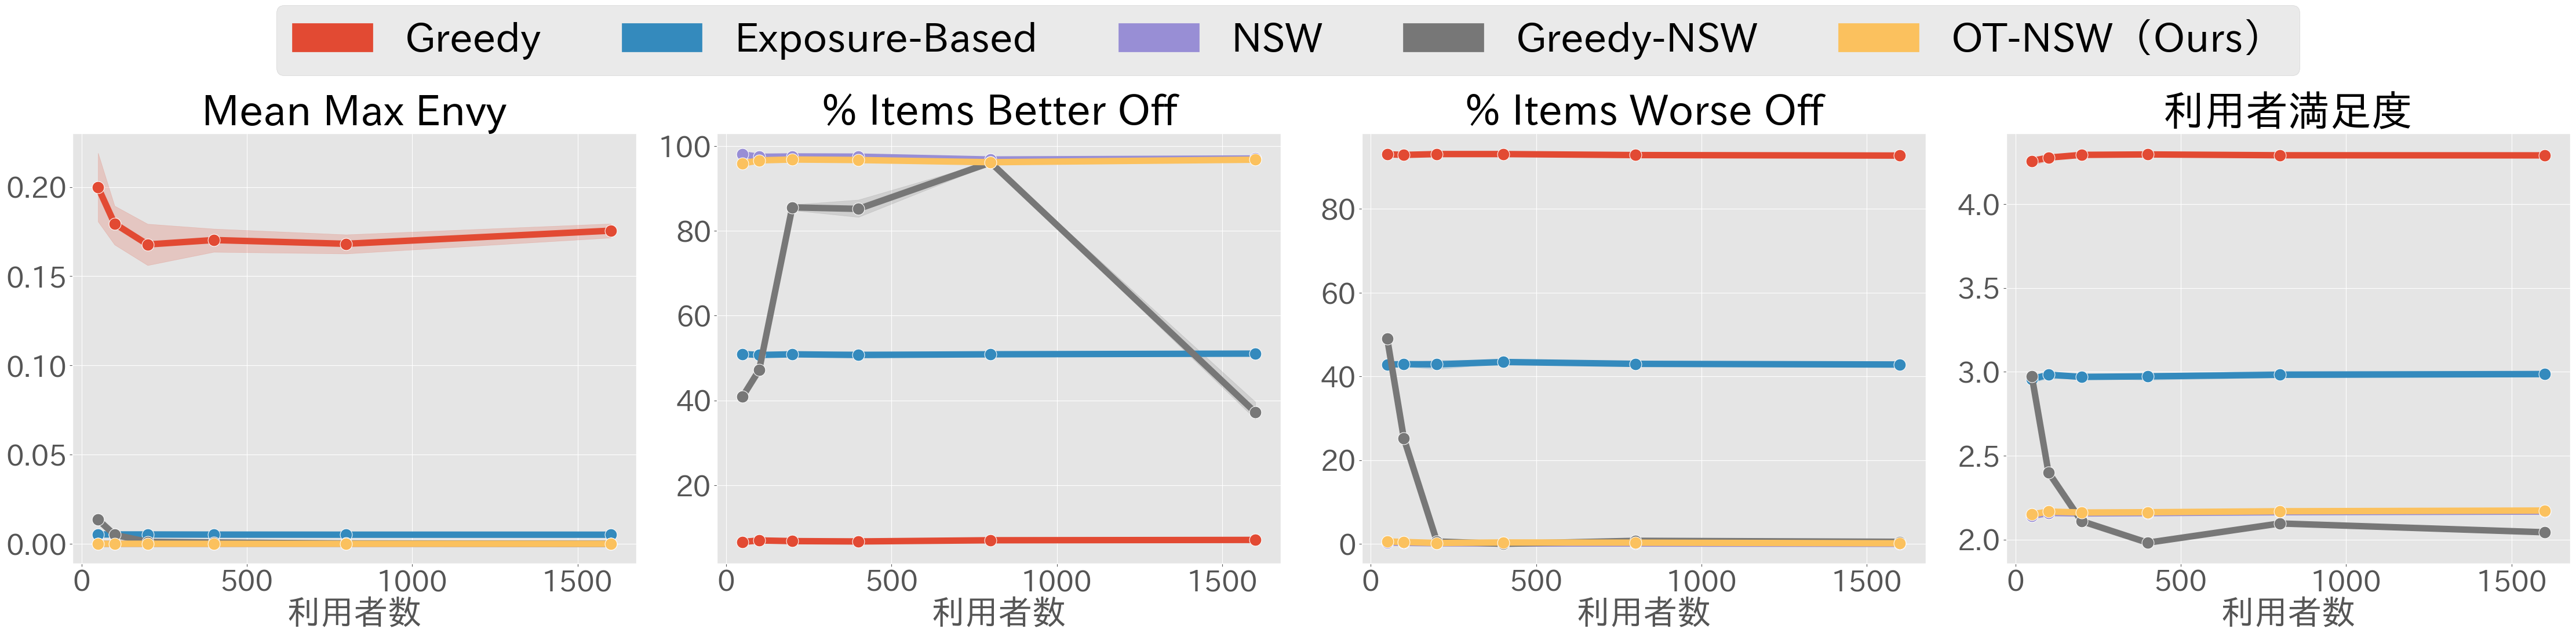

In [144]:
fig, axes = plt.subplots(ncols=4, figsize=(45, 10), tight_layout=True)
axes = np.ravel(axes)
for i, metric in enumerate(
    ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
):
    ax = sns.lineplot(
        varying_user_size_result,
        x="generator_n_query",
        y=metric,
        hue="method",
        ax=axes[i],
        marker="o",
        markersize=15,
        markers=True,
        linewidth=8,
        legend=False,
        palette=PALLETE,
        hue_order=METHOD_NAMES,
    )
    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("利用者数", fontsize=42)
    ax.tick_params(axis="both", labelsize=35)

handles = [plt.Rectangle((0, 0), 1, 1, color=PALLETE[i]) for i in range(len(METHOD_NAMES))]
fig.legend(
    handles,
    METHOD_NAMES,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(METHOD_NAMES),
    loc="upper center",
)

## 実行時間のプロット

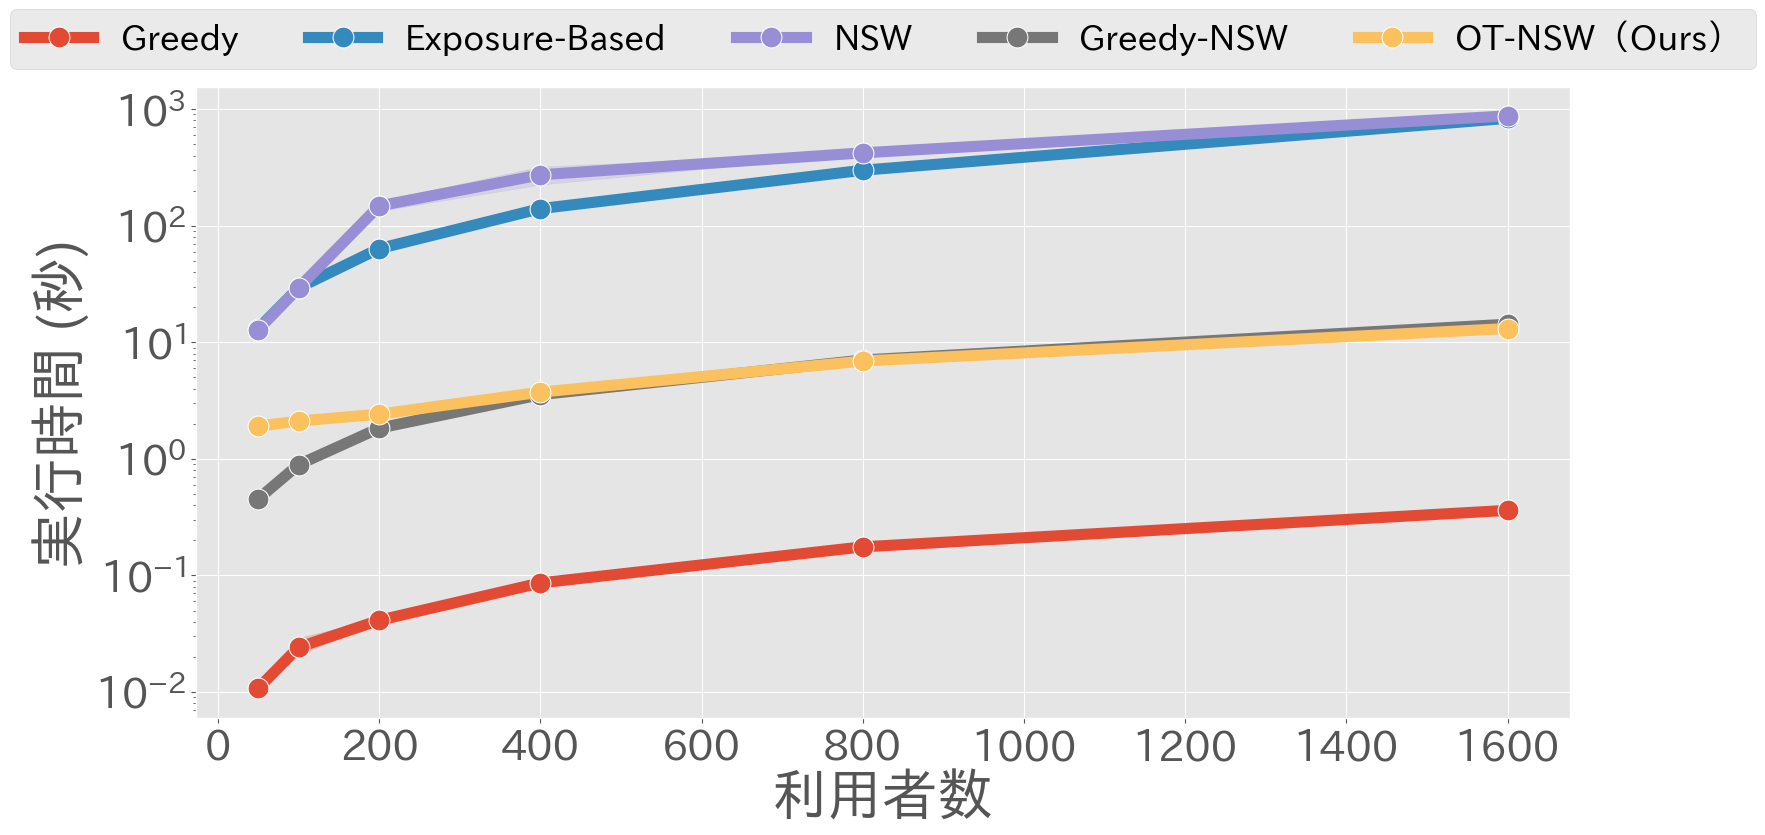

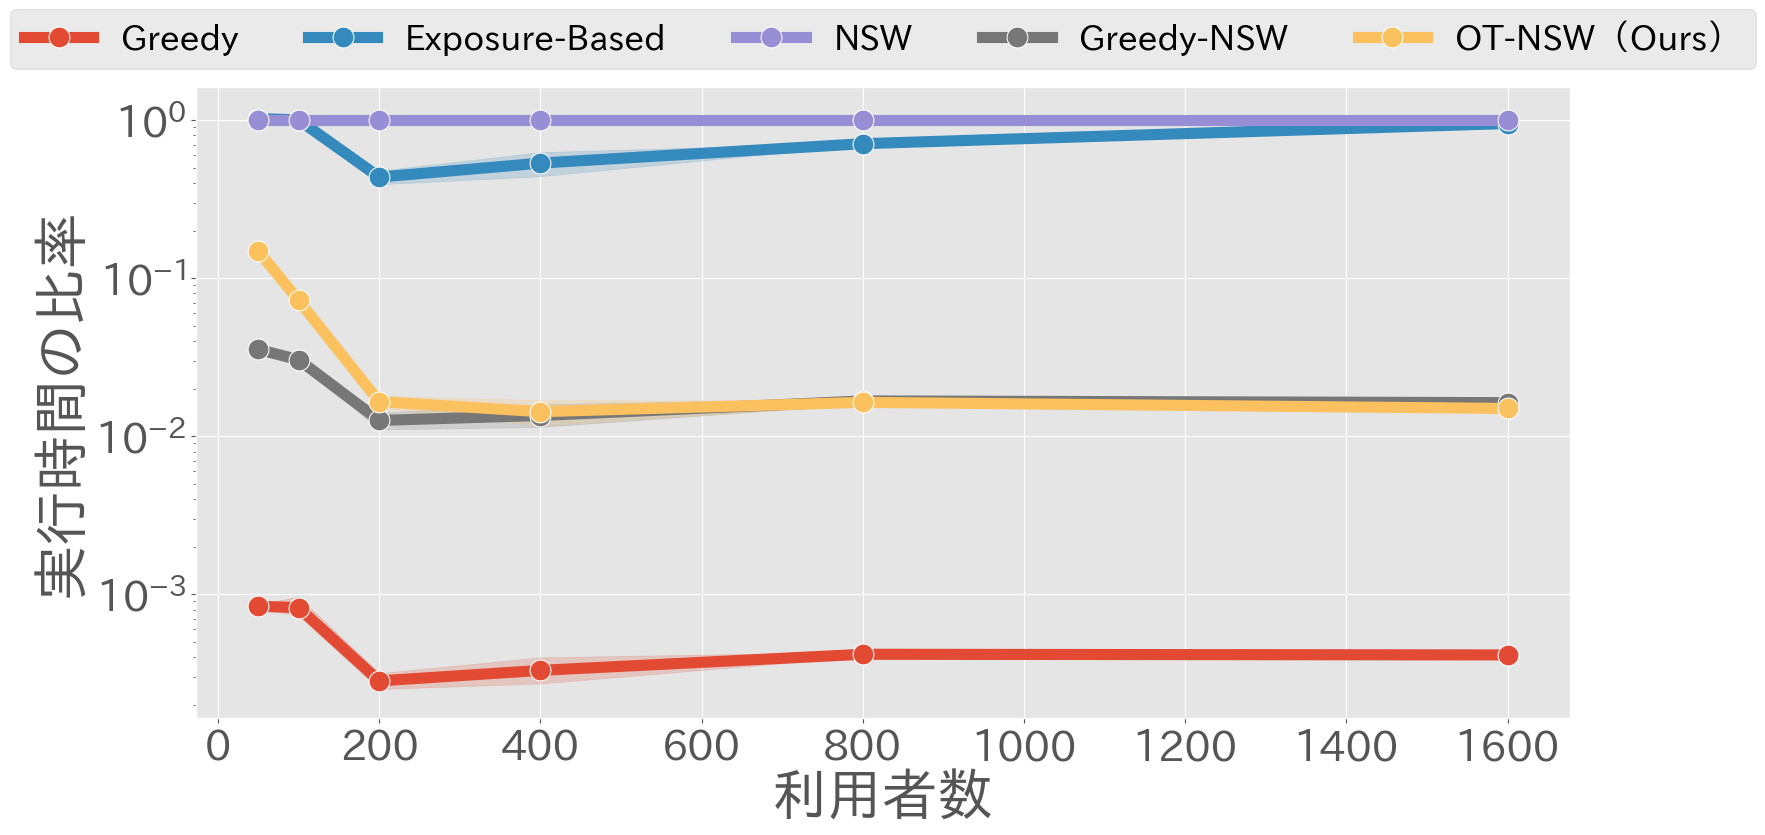

In [145]:
for i, metric in enumerate(["exec_time", "exec_time_rate"]):
    fig = plt.figure(figsize=(18, 9))
    ax = sns.lineplot(
        varying_user_size_result,
        x="generator_n_query",
        y=metric,
        hue="method",
        marker="o",
        markers=True,
        markersize=15,
        linewidth=8,
        legend=True,
        palette=PALLETE,
        hue_order=METHOD_NAMES,
    )
    ax.set_ylabel(METRICS_MAP[metric], fontsize=40)
    ax.set_xlabel("利用者数", fontsize=40)

    if metric in ["exec_time", "exec_time_rate"]:
        ax.set_yscale("log")

    handles, legend = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        legend,
        loc="upper center",
        ncol=len(legend),
        bbox_to_anchor=(0.5, 1.15),
    )
    ax.tick_params(axis="both", labelsize=30)

    fig.tight_layout()